In [14]:
import os
import time
import datetime
import string
from PIL import Image
import logging
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split

from tqdm import *

### Define default settings

In [15]:
current_dir = os.path.abspath(os.path.curdir)
root_dir = os.path.join(current_dir, 'data', 'img')
symbols = string.ascii_lowercase + string.digits
num_symbols = len(symbols)
captcha_length = 5
num_symbols
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device, torch.cuda.is_available(), torch.cuda.get_device_name(), torch.cuda.device_count()

(device(type='cuda'), True, 'NVIDIA GeForce RTX 3070 Laptop GPU', 1)

### Tokenization


In [16]:
int2char = dict(enumerate(symbols))
char2int = {v: k for k, v in int2char.items()}

def tokenize(chars):
    return torch.tensor([char2int[s] for s in list(chars)])

def untokenize(token):
    return ''.join([int2char[i] for i in token.squeeze().tolist()])

### Loading dataset

In [17]:
class Transform(object):
    def __call__(self, x):
        x = transforms.functional.to_grayscale(x)
        x = transforms.functional.to_tensor(x)
        x = transforms.functional.invert(x)
        x = transforms.functional.resize(x, [50, 120])
        x = x > 0.3
        return x.float()

class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform_list = None):
        super(CaptchaDataset, self).__init__()
        self.root_dir = root_dir
        self.images = os.listdir(self.root_dir)
        self.nSamples = len(self.images)
        transform_list = transform_list
        self.transform = transforms.Compose(transform_list)
    
    def __len__(self):
        return self.nSamples
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        labels = tokenize(os.path.splitext(self.images[idx])[0])
        if self.transform is not None:
            image = self.transform(image)
        return image, labels

transform_list = [Transform()]
        
data = CaptchaDataset(root_dir, transform_list=transform_list)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])
print('train size: ' + str(len(train_data)), 'test size: ' + str(len(test_data)))

train size: 400000 test size: 100000


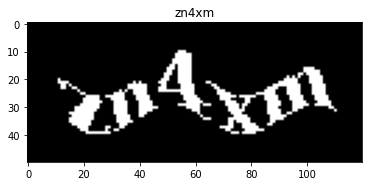

In [18]:
import random
def show_sample_image(dataset):
    idx = random.randint(0, len(dataset))
    img = torch.squeeze(dataset[idx][0]).numpy()
    label = untokenize(dataset[idx][1])
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.show

show_sample_image(train_data)

In [19]:
batch_size=512

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

In [20]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2) # param size: 1 * 16 * 5 * 5
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2) # param size: 32 * 16 * 5 * 5
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2) # param size: 32 * 16 * 5 * 5
        # an affine operation: y = Wx + b
        self.fc1_1 = nn.Linear(64 * 6 * 15, 1024)  
        self.fc1_2 = nn.Linear(64 * 6 * 15, 1024)  
        self.fc1_3 = nn.Linear(64 * 6 * 15, 1024)  
        self.fc1_4 = nn.Linear(64 * 6 * 15, 1024)  
        self.fc1_5 = nn.Linear(64 * 6 * 15, 1024) 
        self.fc2_1 = nn.Linear(1024, num_symbols)  
        self.fc2_2 = nn.Linear(1024, num_symbols)  
        self.fc2_3 = nn.Linear(1024, num_symbols)  
        self.fc2_4 = nn.Linear(1024, num_symbols)  
        self.fc2_5 = nn.Linear(1024, num_symbols)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(0)

    def forward(self, x):
        x = self.conv1(x) 
        x = self.relu(x)
        x = self.pool(x) # output image size: 25 x 60
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x) # output image size: 12 x 30
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x) # output image size: 6 x 15
        x = x.view(x.size()[0], -1) # flatten all dimensions except the batch dimension
        x1 = self.fc1_1(x)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        x1 = self.fc2_1(x1)

        x2 = self.fc1_2(x)
        x2 = self.relu(x2)
        x2 = self.dropout(x2)
        x2 = self.fc2_2(x2)

        x3 = self.fc1_3(x)
        x3 = self.relu(x3)
        x3 = self.dropout(x3)
        x3 = self.fc2_3(x3)

        x4 = self.fc1_4(x)
        x4 = self.relu(x4)
        x4 = self.dropout(x4)
        x4 = self.fc2_4(x4)

        x5 = self.fc1_5(x)
        x5 = self.relu(x5)
        x5 = self.dropout(x5)
        x5 = self.fc2_5(x5)

        outputs = torch.stack((x1, x2, x3, x4, x5,))

        return outputs

In [21]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
model.to(device)
criterion.to(device)

from tqdm.auto import tqdm
epochs = 50
start_time = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
model_dir = os.path.join(current_dir, 'model', 'v1')
os.mkdir(os.path.join(model_dir, start_time))
log_file = os.path.join(model_dir , 'log', start_time + '.log')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
output_handler = logging.FileHandler(log_file)
logger.addHandler(output_handler)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
logger.info(f'scheduler: {scheduler.step_size:^5}, {scheduler.gamma:^5}')

torch.backends.cudnn.benchmark = True
for epoch in range(epochs):
    t0_epoch = time.time()
    model.train()
    train_total, test_total = 0.0, 0.0
    train_loss, train_acc, test_loss, test_acc = 0.0, 0.0, 0.0, 0.0
    loss_list = [0] * captcha_length
    
    for x, label in tqdm(train_dataloader, leave=False):
        x, label = x.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(x)
        for idx, c in enumerate(out):
            loss_list[idx] = criterion(out[idx], label[:, idx])
        loss = sum(loss_list)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = out.argmax(2)
        acc = (pred == torch.transpose(label, 0, 1))
        acc = (torch.all(acc, dim=0)).float().sum()
        train_acc += acc.item()
        train_total += label.size(0)
    scheduler.step()

    model.eval()
    for test_x, test_label in test_dataloader:
        test_x, test_label = test_x.to(device), test_label.to(device)
        optimizer.zero_grad()
        out = model(test_x)
        for idx, c in enumerate(out):
            loss_list[idx] = criterion(out[idx], test_label[:, idx])
        loss = sum(loss_list)

        pred = out.argmax(2)
        test_loss += loss.item()
        acc = (pred == torch.transpose(test_label, 0, 1))
        acc = (torch.all(acc, dim=0)).float().sum()
        test_acc += acc.item()
        test_total += test_label.size(0)

    avg_train_loss = train_loss/ train_total
    avg_train_acc = train_acc/ train_total
    avg_test_loss = test_loss / test_total
    avg_test_acc = test_acc / test_total
    time_elapsed = time.time() - t0_epoch
    print(f"{epoch + 1:^7} | {avg_train_loss:^12.6f} | {avg_train_acc:^12.6f} | {avg_test_loss:^12.6f} | {avg_test_acc:^12.6f} | {time_elapsed:^9.2f}")
    logger.info(f"{epoch + 1:^7} | {avg_train_loss:^12.6f} | {avg_train_acc:^12.6f} | {avg_test_loss:^12.6f} | {avg_test_acc:^12.6f} | {time_elapsed:^9.2f}")

    torch.save(model.state_dict(), os.path.join(model_dir, start_time, str(epoch + 1) + '.pth'))

   1    |   0.012497   |   0.211322   |   0.002781   |   0.673610   |   54.53  


   2    |   0.003290   |   0.589655   |   0.001319   |   0.839190   |   54.22  


   3    |   0.002065   |   0.724150   |   0.000903   |   0.888060   |   53.39  


   4    |   0.001516   |   0.792045   |   0.000577   |   0.931040   |   53.06  


   5    |   0.001182   |   0.834472   |   0.000454   |   0.945330   |   54.43  


   6    |   0.000974   |   0.861433   |   0.000391   |   0.952170   |   53.16  


   7    |   0.000827   |   0.880770   |   0.000326   |   0.959830   |   54.37  


   8    |   0.000725   |   0.894153   |   0.000284   |   0.965970   |   54.27  


   9    |   0.000635   |   0.906150   |   0.000239   |   0.971000   |   53.84  


  10    |   0.000571   |   0.914632   |   0.000218   |   0.974040   |   53.43  


  11    |   0.000393   |   0.940910   |   0.000183   |   0.978890   |   53.68  


  12    |   0.000349   |   0.946688   |   0.000175   |   0.979890   |   53.31  


  13    |   0.000321   |   0.950113   |   0.000175   |   0.978880   |   53.60  


  14    |   0.000306   |   0.952690   |   0.000161   |   0.981710   |   53.57  


  15    |   0.000285   |   0.955538   |   0.000161   |   0.981510   |   53.76  


  16    |   0.000277   |   0.956430   |   0.000149   |   0.983560   |   53.31  


  17    |   0.000265   |   0.958065   |   0.000156   |   0.982610   |   53.61  


  18    |   0.000251   |   0.960457   |   0.000145   |   0.983740   |   53.90  


  19    |   0.000245   |   0.961052   |   0.000149   |   0.984100   |   53.50  


  20    |   0.000228   |   0.963565   |   0.000139   |   0.984550   |   53.25  


  21    |   0.000176   |   0.971775   |   0.000131   |   0.986380   |   53.28  


  22    |   0.000160   |   0.974655   |   0.000128   |   0.986500   |   53.46  


  23    |   0.000150   |   0.975710   |   0.000134   |   0.986150   |   54.28  


  24    |   0.000146   |   0.976325   |   0.000136   |   0.986170   |   54.02  


  25    |   0.000137   |   0.977715   |   0.000130   |   0.986640   |   53.66  


  26    |   0.000136   |   0.977962   |   0.000127   |   0.987050   |   53.65  


  27    |   0.000131   |   0.978695   |   0.000124   |   0.987680   |   53.75  


  28    |   0.000127   |   0.979208   |   0.000130   |   0.987300   |   54.89  


  29    |   0.000125   |   0.979912   |   0.000127   |   0.987510   |   54.37  


  30    |   0.000122   |   0.980113   |   0.000125   |   0.987760   |   54.40  


  31    |   0.000103   |   0.982988   |   0.000125   |   0.988040   |   54.56  


  32    |   0.000095   |   0.984472   |   0.000127   |   0.987840   |   54.26  


  33    |   0.000094   |   0.984610   |   0.000124   |   0.988340   |   54.77  


  34    |   0.000088   |   0.985472   |   0.000126   |   0.988260   |   54.57  


  35    |   0.000090   |   0.985520   |   0.000123   |   0.988530   |   60.22  


  36    |   0.000085   |   0.985980   |   0.000123   |   0.988390   |   54.62  


  37    |   0.000085   |   0.986210   |   0.000126   |   0.988500   |   54.49  


  38    |   0.000082   |   0.986513   |   0.000125   |   0.988550   |   54.78  


  39    |   0.000080   |   0.986790   |   0.000130   |   0.988280   |   54.94  


  40    |   0.000078   |   0.987217   |   0.000130   |   0.988520   |   57.01  


  41    |   0.000074   |   0.987940   |   0.000127   |   0.988690   |   53.84  


  42    |   0.000071   |   0.988485   |   0.000129   |   0.988320   |   53.90  


  43    |   0.000067   |   0.988940   |   0.000122   |   0.989360   |   53.75  


  44    |   0.000068   |   0.988910   |   0.000125   |   0.989170   |   54.01  


  45    |   0.000067   |   0.988765   |   0.000126   |   0.988670   |   53.98  


  46    |   0.000065   |   0.989443   |   0.000129   |   0.988650   |   54.22  


  47    |   0.000064   |   0.989445   |   0.000128   |   0.988570   |   55.13  


  48    |   0.000064   |   0.989677   |   0.000127   |   0.988910   |   53.87  


  49    |   0.000063   |   0.989897   |   0.000127   |   0.988990   |   54.12  


  50    |   0.000062   |   0.989650   |   0.000126   |   0.989290   |   53.71  
